### Run this code with the Exp_1_WithOstacles.ttt Scene open

## Villela-Braitenberg

In [2]:
from __future__ import print_function
import gym
import gym_kheperaposition
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

Vmax=0.05
Wmax=math.pi/4
L=0.1
Kr_V_RL=0.05   # radio de seguridad
Kr_Prop=0.025 
# mostrar el entorno

noDetectionDistance=0.2 

# Parametros para Braintenberg
braitFrontSens_leftMotor=[5,3,2]       
braitFrontSens_rightMotor=[-5,-3,-2]
braitSideSens_leftMotor=[6,-6]
braitFrontLateralSens_leftMotor=[4,-4]

def BraitenbergControl(v,w,S):

    S = [(abs(sensor-1)*0.2)  for sensor in S]
    Vri=(2*v+w*0.1)/2     
    Vle=(2*v-w*0.1)/2

    if S[3]==noDetectionDistance:
        if S[2]+S[4]+S[1]+S[5]<=noDetectionDistance*4:
            if S[1]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitSideSens_leftMotor[0]*(1-(S[1]/noDetectionDistance))                   
                Vri = Vri + Vmax*braitSideSens_leftMotor[1]*(1-(S[1]/noDetectionDistance))
            if S[2]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitFrontLateralSens_leftMotor[0]*(1-(S[2]/noDetectionDistance))                    
                Vri = Vri + Vmax*braitFrontLateralSens_leftMotor[1]*(1-(S[2]/noDetectionDistance))            
            if S[4]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitFrontLateralSens_leftMotor[1]*(1-(S[4]/noDetectionDistance))                    
                Vri = Vri + Vmax*braitFrontLateralSens_leftMotor[0]*(1-(S[4]/noDetectionDistance))                
            if S[5]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitSideSens_leftMotor[1]*(1-(S[5]/noDetectionDistance))
                Vri = Vri + Vmax*braitSideSens_leftMotor[0]*(1-(S[5]/noDetectionDistance))
    else:
        for i in range(3):
            Vle = Vle + Vmax*braitFrontSens_leftMotor[i]*(1-(S[i+2]/noDetectionDistance))
            Vri = Vri + Vmax*braitFrontSens_rightMotor[i]*(1-(S[i+2]/noDetectionDistance))
            
    lineal=(Vri+Vle)/2
    angular=(Vri-Vle)/0.1
        
    if angular>Wmax:
        angular=Wmax
    if angular<-Wmax:
        angular=-Wmax

    return(lineal,angular) 
 

def random_agent(steps=1100):
    episode_reward = 0
    ErrorAcumulado=0
    env = gym.make('KheperaPositionObstacle-v0')
    env.MaxSteps = steps
    env.Randomize = False
    env.RobotOrientationRand = False
    env.radius = 0.95
    #env.change_target_angle(45)
    state = env.reset()
    d,Oc,vp,wp,s1,s2,s3,s4,s5,s6,s7,s8 = state
    sensors = [s1,s2,s3,s4,s5,s6,s7,s8]
    #env.render()
    ISE_acumulado = 0
    IAE_acumulado = 0
    ITSE_acumulado = 0
    ITAE_acumulado = 0
    
    data = {}
    paso = []
    infoOc = []
    infoD = []
    Lineal = []
    Angular = []
    xc = []
    yc = []

    
    for e in range(steps):
        
        w = Wmax*math.sin(Oc)
        if d > Kr_V_RL:
            v = Vmax
        else:
            v = d*(Vmax/Kr_V_RL)
        if d < 0.02:
            v = 0
            w = 0
        v,w = BraitenbergControl(v,w,sensors)
        
        if d < Kr_Prop:
            v = 0
            w = 0
        
        v = v/Vmax
        w = w/Wmax
        
        action = [v,w]
        state, reward, done, info = env.step(action)
        d,Oc,vp,wp,s1,s2,s3,s4,s5,s6,s7,s8 = state
        sensors = [s1,s2,s3,s4,s5,s6,s7,s8]
        #env.render()
        #print(reward)
        print(reward, end='\r')
        sys.stdout.flush()

        episode_reward += reward
        x = info['xc']
        y = info['yc']
        
        paso.append(e)
        infoOc.append(float(Oc))
        infoD.append(float(d))
        Lineal.append(float(v))
        Angular.append(float(w))
        xc.append(float(x))
        yc.append(float(y))
             
        if done:
            print('Reward of the episode is: ',episode_reward)
            break
    env.close()
   
    data={'paso' : paso,
          'Oc' : infoOc,
          'Distance' : infoD,
          'Lineal' : Lineal,
          'Angular' : Angular,
          'xc' : xc,
          'yc' : yc}
    
    #print(data)
    return data
data1 = random_agent()


d, t = [np.array(data1['Distance']), 0.05*np.array(data1['paso'])]

IAE = np.trapz(abs(d),t)
ISE = np.trapz(d**2,t)
ITAE = np.trapz(t*abs(d),t)
ITSE = np.trapz(t*(d**2),t)

Villela_Braitenberg = [ISE, IAE, ITSE, ITAE]

print(IAE)
print(ISE)
print(ITAE)
print(ITSE)

Connected to remote API server
Reward of the episode is:  -575.8751599738376
33.52534510909477
33.75781573883499
499.9355620261929
388.5324952444546


# DQN

In [3]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
env.MaxSteps = 5000
env.radius = 0.95
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]
#env.change_target_angle(45)
env.Randomize = False
env.RobotOrientationRand = False

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')


log_filename = 'test.pckl'
logger = [TestLogger()]

dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
env.close()

import pickle
f = open(log_filename, 'rb')
data3 = pickle.load(f)
f.close()
#print(data3)

d, t = [np.array(data3['Distance']), 0.05*np.array(data3['paso'])]

IAE = np.trapz(abs(d),t)
ISE = np.trapz(d**2,t)
ITAE = np.trapz(t*abs(d),t)
ITSE = np.trapz(t*(d**2),t)

print(IAE)
print(ISE)
print(ITSE)
print(ITAE)


DQN = [ISE, IAE, ITSE, ITAE]

Connected to remote API server
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)

## DDPG

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.Randomize = False
env.MaxSteps = 1000
env.radius = 0.95
#env.change_target_angle(45)
env.Randomize = False
env.RobotOrientationRand = False
env.training = True

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger

pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
env.close()

import pickle
f = open(log_filename, 'rb')
data4 = pickle.load(f)
f.close()
#print(data3)

d, t = [np.array(data4['Distance']), 0.05*np.array(data4['paso'])]

IAE = np.trapz(abs(d),t)
ISE = np.trapz(d**2,t)
ITAE = np.trapz(t*abs(d),t)
ITSE = np.trapz(t*(d**2),t)

print(IAE)
print(ISE)
print(ITSE)
print(ITAE)


DDPG = [ISE, IAE, ITSE, ITAE]

Connected to remote API server
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          6656        flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          262656      dense_4[0][0]                    
________________________________________________________

## Gráficos de Velocidad Lineal y Angular

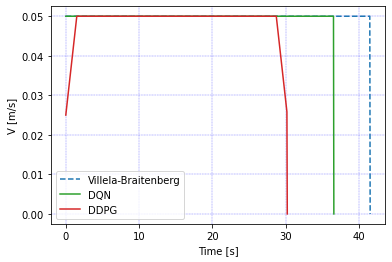

In [5]:
def smooth(y, box_pts=60):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

v3,w3 = [data3['Lineal'], data3['Angular']]
v4,w4 = [data4['Lineal'], data4['Angular']]
v1,w1 = [data1['Lineal'], data1['Angular']]
#v1 = smooth(v1)

w1 = np.array(w1)*Wmax

w1 = smooth(w1)
w3 = smooth(w3)
w4 = smooth(w4)
w1 = smooth(w1)
w3 = smooth(w3)
w4 = smooth(w4)

v1 = np.array(v1)*Vmax
v4 = smooth(v4)


v1[len(v1)-1] = 0
v3[len(v3)-1] = 0
v4[len(v4)-1] = 0

t1 = np.array(data1['paso'])*0.05
t3 = np.array(data3['paso'])*0.05
t4 = np.array(data4['paso'])*0.05
plt.figure(figsize=(6,4))
plt.plot(t1,v1, '--',label='Villela-Braitenberg', color='tab:blue')
plt.plot(t3,v3, label='DQN', color='tab:green')
plt.plot(t4,v4, label='DDPG', color='tab:red')

#plt.title('Velocidad Lineal')
plt.xlabel('Time [s]')
plt.ylabel('V [m/s]')
plt.legend()
plt.grid(color='b', ls = '-.', lw = 0.25)
#plt.savefig('Lineal Velocity_obstacle.svg', format='svg', dpi=1200)
plt.show()

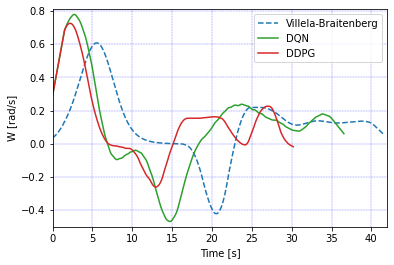

In [12]:
plt.figure(figsize=(6,4))
w1 = [element * -1 for element in w1]
w3 = [element * -1 for element in w3]
w4 = [element * -1 for element in w4]

plt.plot(t1,w1, '--',label='Villela-Braitenberg', color='tab:blue')
plt.plot(t3,w3, label='DQN', color='tab:green')
plt.plot(t4,w4, label='DDPG', color='tab:red')

#plt.title('Velocidad Angular')
plt.xlabel('Time [s]')
plt.ylabel('W [rad/s]')
plt.legend()
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xlim([0, 42]) 
plt.ylim([-0.5, 0.81]) 
#plt.savefig('Angular_Velocity_obstacle.svg', format='svg', dpi=1200)
plt.show()

## Indices de Rendimiento

![](Performance_index.png)

In [7]:
def aproximar(algoritmo):
    for i in range(len(algoritmo)):
        algoritmo[i] = round(algoritmo[i], 2)
    return algoritmo

Villela_Braitenberg = aproximar(Villela_Braitenberg)
DQN = aproximar(DQN)
DDPG = aproximar(DDPG)

In [8]:
from tabulate import tabulate
Index = ['ISE','IAE','ITSE','IATE']
PerformanceIndex = {'Index':Index,
                    'Villela-B': Villela_Braitenberg,
                    'DQN': DQN,
                    'DDPG' : DDPG}
print('Experimental Data')
print('')
print(tabulate(PerformanceIndex, headers='keys'))

Experimental Data

Index      Villela-B     DQN    DDPG
-------  -----------  ------  ------
ISE            33.76   22.9    19.19
IAE            33.53   26.14   21.4
ITSE          388.53  234.37  154.92
IATE          499.94  348.43  227.4


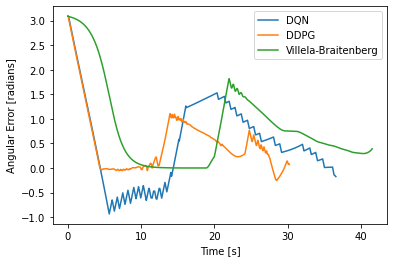

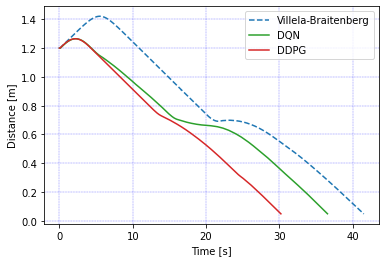

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(t3,data3['Oc'], label='DQN')
plt.plot(t4,data4['Oc'], label='DDPG')
plt.plot(t1,data1['Oc'], label='Villela-Braitenberg')
plt.xlabel('Time [s]')
plt.ylabel('Angular Error [radians]')
plt.legend()
plt.show()
plt.figure(figsize=(6,4))
plt.plot(t1,data1['Distance'], '--',label='Villela-Braitenberg', color='tab:blue')
plt.plot(t3,data3['Distance'], label='DQN', color='tab:green')
plt.plot(t4,data4['Distance'], label='DDPG', color='tab:red')
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.legend()
plt.grid(color='b', ls = '-.', lw = 0.25)
#plt.savefig('Distance_obstacle.svg', format='svg', dpi=1200)
plt.show()

## Grafico de la trayectoria

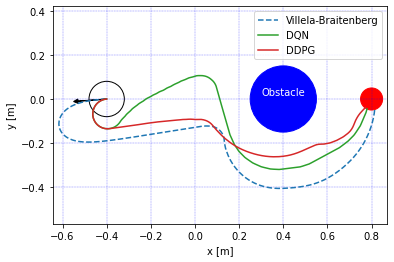

In [10]:
def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

def set_ymargin(ax, up=0.0, down=0.3):
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    up = lim[0] - delta*up
    down = lim[1] + delta*down
    ax.set_ylim(up, down)

x3,y3 = [data3['xc'],data3['yc']]
x3 = [element * -1 for element in x3]
x4,y4 = [data4['xc'],data4['yc']]
x4 = [element * -1 for element in x4]
x1,y1 = [data1['xc'],data1['yc']]
x1 = [element * -1 for element in x1]
fig, ax = plt.subplots(figsize=(6,4))
tp = plt.Circle((0.8, 0), .05, color='r')
robot = plt.Circle((-0.4,0), 0.08, color='k', fill=False)
obstacle = plt.Circle((0.4,0), 0.15, color='b')
ax.arrow(-0.4, 0, -0.13, -0.01, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.add_artist(tp)
ax.add_artist(robot)
ax.add_artist(obstacle)
ax.plot(y1,x1, '--',label='Villela-Braitenberg', color='tab:blue')
ax.plot(y3,x3, label='DQN', color='tab:green')
ax.plot(y4,x4, label='DDPG', color='tab:red')
ax.legend()
ax.axis('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.text(0.3,0.017, 'Obstacle', color='white')
ax.grid(color='b', ls = '-.', lw = 0.25)
set_xmargin(ax, left=0.02, right=0.04)
set_ymargin(ax, up=0, down=0.3)
#ax.set_ylim(ax.get_ylim()[::-1])
#fig.savefig('Trajectory_obstacle.svg', format='svg', dpi=1200)
#fig.show()

In [11]:
print('DQN: ',len(data3['paso'])*0.05)
print('DDPG: ',len(data4['paso'])*0.05)
print('Villela-B: ',len(data1['paso'])*0.05)

DQN:  36.6
DDPG:  30.25
Villela-B:  41.550000000000004
